# Часть 1. Анализ пользовательского поведения в Яндекс Книгах и проверка A/B-теста

### 👤 Автор проекта

**Артем Байков**  
**14.04.2025**

## Описание данных

В первой части проекта анализируются данные о пользователях сервиса Яндекс Книги. Основная цель — изучить активность пользователей из Москвы и Санкт-Петербурга и проверить гипотезу о различии их поведения.

Вторая часть посвящена анализу результатов A/B-теста на других данных, которые включают в себя группы пользователей, метрики и условия эксперимента.

**Файл `yandex_knigi_data.csv` содержит:**
- `city` — город пользователя (Москва или Санкт-Петербург);
- `puid` — уникальный идентификатор пользователя;
- `hours` — общее количество часов активности (чтение или прослушивание контента).


## 🎯 Цель проекта

Цель проекта — проверить гипотезу о том, что пользователи из Санкт-Петербурга **проводят в среднем больше времени за чтением и прослушиванием контента** в сервисе **Яндекс Книги**, чем пользователи из Москвы. Анализ проводится с использованием агрегированных данных по пользователям и одностороннего t-теста для двух независимых выборок.

---

## 🧭 Этапы проекта

1. **Импорт и подготовка данных:**
   - Загрузка агрегированных данных (`city`, `puid`, `hours`);
   - Проверка на наличие дубликатов в идентификаторах пользователей;
   - Предварительное сравнение выборок (размер, средние значения, дисперсии).

2. **Проверка гипотезы:**
   - Формализация гипотез:
     - **Нулевая гипотеза (H₀)**: среднее время активности пользователей из Санкт-Петербурга **не больше**, чем у пользователей из Москвы.
     - **Альтернативная гипотеза (H₁)**: пользователи из Санкт-Петербурга **проводят больше времени** в приложении.
   - Выбор подходящего t-теста и уровня значимости (например, α = 0.05);
   - Проведение одностороннего t-теста для двух независимых выборок;
   - Расчёт p-value и вывод результата.

3. **Интерпретация результатов:**
   - Интерпретация p-value и принятие или отклонение нулевой гипотезы;
   - Формулировка возможных причин различий в поведении пользователей;
   - Подготовка аналитической записки с результатами анализа.

---

📌 В конце проекта будет сделан статистический вывод и предложены объяснения наблюдаемых различий в активности пользователей двух городов.



In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from math import ceil
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import levene
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [9]:
# Пути
local_path = 'yandex_knigi_data.csv'
remote_url = 'https://code.s3.yandex.net/datasets/yandex_knigi_data.csv'

# Если файл уже есть локально — читаем из него, иначе — скачиваем
if os.path.exists(local_path):
    df = pd.read_csv(local_path)
    print("✅ Данные загружены из локального файла")
else:
    df = pd.read_csv(remote_url)
    print("🌐 Данные загружены по ссылке")
    # Сохраняем локально на будущее (опционально)
    df.to_csv(local_path, index=False)
    print("💾 Файл сохранён локально")

# Просмотр первых строк
df.head()

✅ Данные загружены из локального файла


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [10]:
df = df.drop(columns=['Unnamed: 0'])

In [13]:
# Проверим количество уникальных пользователей и общее количество строк
total_rows = len(df)
unique_users = df['puid'].nunique()

print(f'Всего строк в данных: {total_rows}')
print(f'Уникальных пользователей: {unique_users}')
print(f'Количество дубликатов: {total_rows - unique_users}')

Всего строк в данных: 8784
Уникальных пользователей: 8540
Количество дубликатов: 244


In [14]:
# Удалим дубликаты по идентификатору пользователя (оставим первую строку)
df_dedup = df.drop_duplicates(subset='puid', keep='first')

print(f'Размер данных до удаления дубликатов: {len(df)}')
print(f'Размер данных после удаления дубликатов: {len(df_dedup)}')


Размер данных до удаления дубликатов: 8784
Размер данных после удаления дубликатов: 8540


In [16]:
# Ищем пользователей, у которых более одного уникального значения 'city'
user_city_counts = df_dedup.groupby('puid')['city'].nunique()
overlap_users = user_city_counts[user_city_counts > 1]

print(f'Количество пользователей, указанных в более чем одном городе: {len(overlap_users)}')

Количество пользователей, указанных в более чем одном городе: 0


### Сравнение описательных статистик по городам

Перед проведением проверки гипотез важно сравнить группы по ключевым статистическим характеристикам:
- размер выборки;
- среднее и медиану активности;
- стандартное отклонение;
- минимальные и максимальные значения.

Это позволит понять, насколько выборки сбалансированы и можно ли применять параметрический тест.

In [19]:
# Сравнение размеров выборок и описательных статистик
group_sizes = df_dedup['city'].value_counts()
print("Размеры выборок:\n", group_sizes, "\n")

group_stats = df_dedup.groupby('city')['hours'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)
print("Описательные статистики:\n", group_stats)

Размеры выборок:
 city
Москва             6234
Санкт-Петербург    2306
Name: count, dtype: int64 

Описательные статистики:
                  count   mean  median    std  min     max
city                                                     
Москва            6234  10.88    0.92  36.85  0.0  857.21
Санкт-Петербург   2306  11.26    0.88  39.83  0.0  978.76


### 📌 Предварительные выводы

На основе описательных статистик и анализа данных можно сделать следующие выводы:

- **Размеры выборок существенно различаются**: в Москве — 6234 пользователя, в Санкт-Петербурге — 2306.  
  → Разница превышает 25%, что уже требует осторожности при выборе параметрических тестов.

- **Распределения времени активности асимметричны и содержат выбросы**, особенно в группе СПб,  
  что подтверждается разбросом значений и большим стандартным отклонением.

- **Медианы почти совпадают**, в то время как средние значения и стандартные отклонения различаются.

---

📌 **Вывод:**
- Тест **на равенство дисперсий** (Levene test) обязателен, чтобы подтвердить или опровергнуть равенство дисперсий.
- При проверке гипотезы о разнице средних:
  - будем использовать **Welch’s t-test** — учитывает неравные размеры выборок;
  - а также **Mann–Whitney U-test** — более устойчив к выбросам и асимметрии.

Оба метода дадут полную картину и позволят корректно интерпретировать различия между группами.



#### 📏 Сравнение размеров выборок

| Город            | Кол-во пользователей |
|------------------|----------------------|
| Москва           | 6234                 |
| Санкт-Петербург  | 2306                 |

→ Разница в размере между группами составляет **более 60%**,  
что превышает допустимый порог в 25% для использования классического t-test без поправки.  

❗ Поэтому при проверке гипотезы будет применяться **Welch’s t-test** — метод, устойчивый к неравенству выборок.


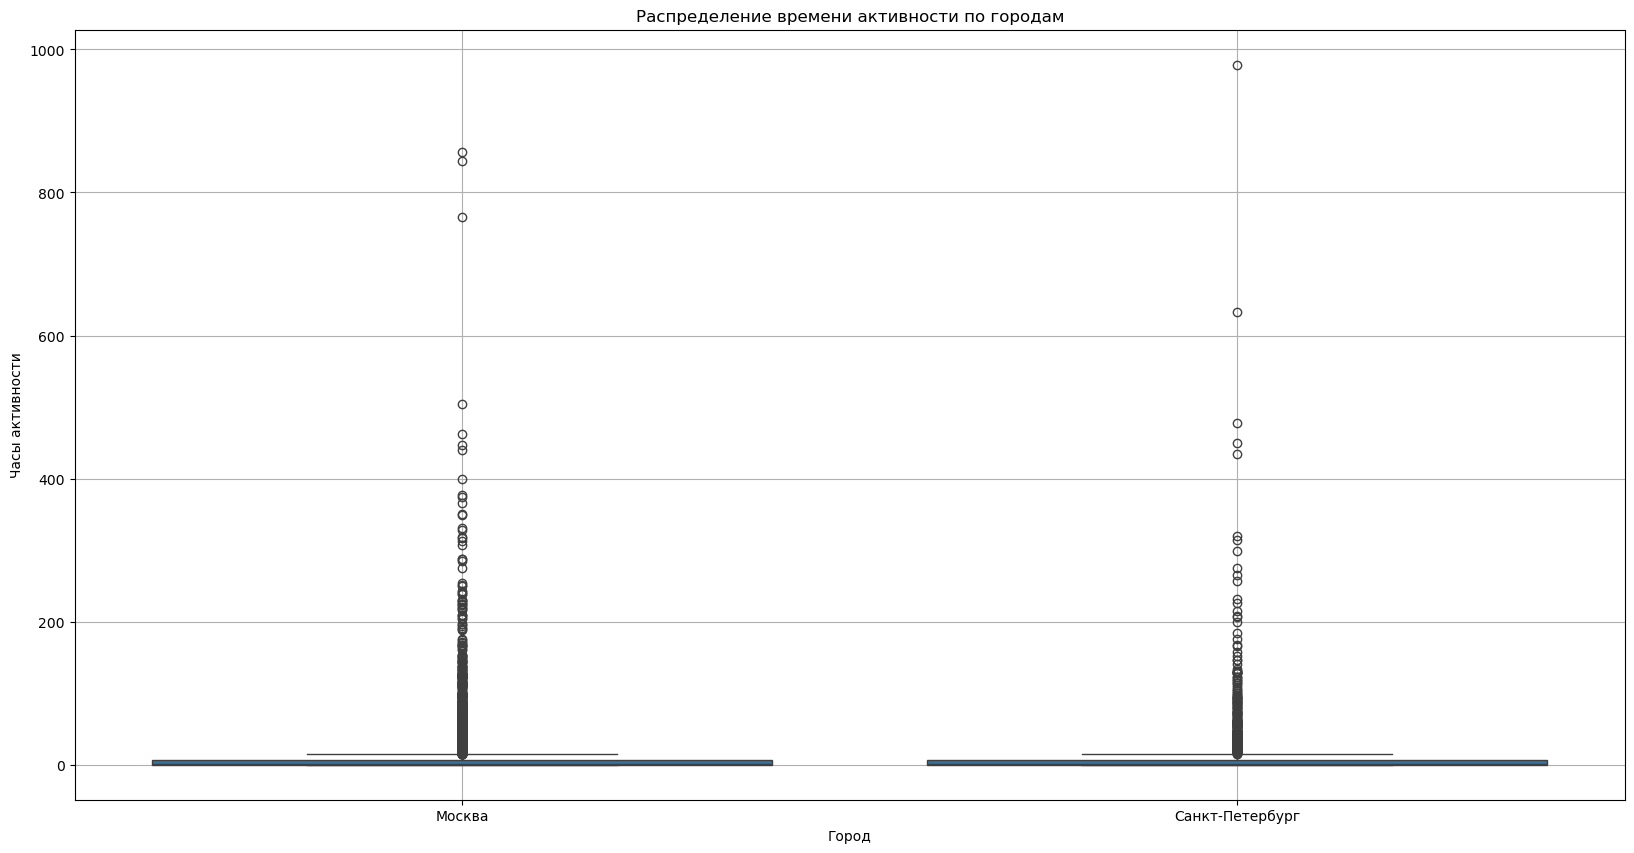

In [28]:
# Визуализация boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(x='city', y='hours', data=df_dedup)
plt.title('Распределение времени активности по городам')
plt.ylabel('Часы активности')
plt.xlabel('Город')
plt.grid(True)
plt.show()

###  📉 Вывод на основе визуального анализа

- Данные содержат **значительное количество выбросов**;
- Распределения **асимметричны** и имеют вытянутые хвосты;
- **Размеры выборок отличаются более чем на 25%**.

📌 **Вывод**: проводить параметрический тест на "сырых" данных нецелесообразно.

---

###  🧹 Подготовка данных к проверке гипотезы

Чтобы корректно провести параметрический тест, мы:
- удалим выбросы по правилу межквартильного размаха (IQR),
- применим **Welch’s t-test**, устойчивый к разному размеру выборок,
- не будем использовать Mann–Whitney U — так как устранили проблему выбросов.

---

📘 *После очистки данных и удаления выбросов проверим основную гипотезу:*

> **H₀:** Среднее время активности в Санкт-Петербурге не больше, чем в Москве  
> **H₁:** Среднее время активности в Санкт-Петербурге больше, чем в Москве


#### 📤 Удаление выбросов

Чтобы сделать выборки сопоставимыми и применить параметрический тест, устраним выбросы по правилу межквартильного размаха (IQR) — для каждой группы отдельно:

- Отсекаем данные, которые лежат за пределами [Q1 − 1.5 * IQR; Q3 + 1.5 * IQR]
- Это позволит снизить влияние аномальных значений и сделать t-test корректным.


In [31]:
# Вычислим границы IQR для каждой группы по отдельности
def remove_outliers_iqr(data, city_col='city', value_col='hours'):
    cleaned_data = pd.DataFrame()
    
    for city in data[city_col].unique():
        city_data = data[data[city_col] == city]
        q1 = city_data[value_col].quantile(0.25)
        q3 = city_data[value_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        filtered = city_data[(city_data[value_col] >= lower) & (city_data[value_col] <= upper)]
        cleaned_data = pd.concat([cleaned_data, filtered], ignore_index=True)
    
    return cleaned_data

# Применим функцию к исходным данным без дубликатов
df_filtered = remove_outliers_iqr(df_dedup)

# Проверим размер и статистику после удаления выбросов
print("Размер выборки после удаления выбросов:\n", df_filtered['city'].value_counts())
print("\nСтатистики:\n", df_filtered.groupby('city')['hours'].describe().round(2))


Размер выборки после удаления выбросов:
 city
Москва             5334
Санкт-Петербург    1960
Name: count, dtype: int64

Статистики:
                   count  mean   std  min   25%   50%   75%    max
city                                                             
Москва           5334.0  2.06  3.18  0.0  0.04  0.49  2.68  14.76
Санкт-Петербург  1960.0  2.03  3.27  0.0  0.04  0.47  2.61  15.20


In [32]:
# Выделим данные после удаления выбросов
moscow_hours = df_filtered[df_filtered['city'] == 'Москва']['hours']
spb_hours = df_filtered[df_filtered['city'] == 'Санкт-Петербург']['hours']


t_stat, p_value = ttest_ind(spb_hours, moscow_hours, equal_var=False)

# Преобразуем в одностороннюю проверку
p_one_sided = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)

# Вывод результатов
print(f"t-статистика: {t_stat:.4f}")
print(f"Односторонний p-value: {p_one_sided:.4f}")

alpha = 0.05
if p_one_sided < alpha:
    print("✅ Отвергаем H₀: средняя активность в СПб статистически выше, чем в Москве.")
else:
    print("❌ Нет оснований отвергнуть H₀.")


t-статистика: -0.3666
Односторонний p-value: 0.6430
❌ Нет оснований отвергнуть H₀.


### 📊  — Вывод по результатам проверки гипотезы

- После удаления выбросов распределения по городам стали более сопоставимыми.
- Проведён **односторонний t-тест Уэлча**, устойчивый к неравенству дисперсий.

> **Результаты теста:**
> - t-статистика = -0.3666  
> - p-value (односторонний) = 0.6430

🔬 **Статистический вывод:**  
На уровне значимости **α = 0.05** нет оснований отвергнуть нулевую гипотезу.  
Это означает, что **разница в среднем времени активности между пользователями из Санкт-Петербурга и Москвы статистически незначима**.

💼 **Что это значит для бизнеса:**  
- Поведение пользователей из двух крупнейших городов **схоже** с точки зрения времени, проводимого в сервисе.
- Это позволяет применять **унифицированные маркетинговые стратегии** и продуктовые решения сразу для обоих городов.
- Нет необходимости в **дополнительной локализации или персонализации** интерфейса/функционала по этим регионам — можно сосредоточиться на масштабируемых улучшениях.


---
🧩 Переход ко второй части проекта: анализ A/B-теста

⬇️ Ниже начинается новая аналитическая задача. Теперь анализируем поведение пользователей на сайте BitMotion с помощью A/B-тестирования.

---


# Часть 2. Анализ A/B-теста редизайна сайта интернет-магазина BitMotion Kit

## Цель проекта

Цель проекта — проанализировать корректность и результаты A/B-теста, проведённого интернет-магазином BitMotion Kit, и определить, привёл ли новый интерфейс к увеличению доли пользователей, совершающих покупку.

Тест затрагивает пользователей, зарегистрировавшихся в системе, и сравнивает конверсии в течение 7 дней после регистрации.

---

## Этапы проекта:

1. Загрузка данных и ознакомление со структурой;
2. Проверка на дубликаты и пропущенные значения;
3. Предобработка данных;
4. Проверка корректности проведения A/B-теста;
5. Проверка гипотезы с использованием статистических методов;
6. Формулировка выводов и рекомендации для бизнеса.

___

## Описание данных

**Датасет 1 — Участники A/B-теста (`ab_test_participants.csv`)**:
- `user_id` — уникальный идентификатор пользователя;
- `group` — группа пользователя (`A` — контроль, `B` — новый интерфейс);
- `ab_test` — название теста (в нашем случае `interface_eu_test`);
- `device` — устройство пользователя при регистрации.

**Датасет 2 — События пользователей (`ab_test_events.csv`)**:
- `user_id` — уникальный идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии (если есть).


In [48]:
import zipfile
import requests
from io import BytesIO
from statsmodels.stats.power import zt_ind_solve_power

In [49]:
events_df = pd.read_csv(
    "https://code.s3.yandex.net/datasets/ab_test_events.zip", 
    compression='zip', 
    low_memory=False
)

# Проверим первые строки
events_df.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


## Загрузка таблицы участников A/B-теста

Теперь загрузим второй файл — таблицу с распределением пользователей по тестовым группам.


In [52]:
# Загрузка CSV-файла с участниками теста
participants_df = pd.read_csv("https://code.s3.yandex.net/datasets/ab_test_participants.csv")

# Выводим первые строки
participants_df.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


### Проверка данных на дубликаты и пропуски

Прежде чем приступать к объединению и анализу, проверим оба датасета на наличие:

- дубликатов,
- пропущенных значений.

Это поможет убедиться, что данные корректны и не содержат артефактов, способных исказить результаты A/B-теста.


In [54]:
# Проверка таблицы участников
print("📋 Участники A/B-теста:")
print("Дубликаты по user_id:", participants_df.duplicated(subset='user_id').sum())
print("Пропуски:\n", participants_df.isna().sum())

# Проверка таблицы событий
print("\n📋 События пользователей:")
print("Дубликаты по строкам:", events_df.duplicated().sum())
print("Пропуски:\n", events_df.isna().sum())

📋 Участники A/B-теста:
Дубликаты по user_id: 887
Пропуски:
 user_id    0
group      0
ab_test    0
device     0
dtype: int64

📋 События пользователей:
Дубликаты по строкам: 36318
Пропуски:
 user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


## ✅ Результаты проверки на дубликаты и пропуски

**📋 Участники A/B-теста (`ab_test_participants.csv`):**
- Найдено **887 дубликатов по `user_id`**, необходимо оставить только первую запись;
- Пропущенные значения отсутствуют.

**📋 События пользователей (`ab_test_events.csv`):**
- Обнаружено **36 318 полных дубликатов строк** — они подлежат удалению;
- Пропуски есть только в поле `details` — это допустимо, так как оно содержит необязательную дополнительную информацию.

📌 Сделан вывод, что данные можно использовать для анализа после очистки от дубликатов и фильтрации по нужному тесту.
___

## Предобработка данных

Перед анализом необходимо убедиться, что данные подготовлены корректно. Для этого:

- 📌 Проверим, что **каждый пользователь участвует только в одной группе** теста — A или B. Если пользователь попал в обе группы, его данные нужно исключить.
- 🔍 Отфильтруем данные только по нужному A/B-тесту — `interface_eu_test`.
- 🔗 Объединим события с участниками теста.
- ✅ Убедимся, что анализируем только события, произошедшие **после регистрации** пользователя.

После этих шагов мы получим чистые данные, подходящие для анализа результатов A/B-теста.


In [57]:
# 1. Удалим полные дубликаты из таблицы событий
events_df = events_df.drop_duplicates()

# 2. Оставим участников только теста interface_eu_test
participants_filtered = participants_df[participants_df['ab_test'] == 'interface_eu_test']

# 3. Фильтруем события по этим участникам
events_filtered = events_df[events_df['user_id'].isin(participants_filtered['user_id'])].copy()

# Проверим результат
print(f"Уникальных участников: {participants_filtered['user_id'].nunique()}")
print(f"Событий после фильтрации: {events_filtered.shape[0]}")


Уникальных участников: 10850
Событий после фильтрации: 73545


## 🔎 Проверка корректности: уникальность распределения по группам

Важно убедиться, что **каждый пользователь участвует только в одной группе** A/B-теста. Если один и тот же `user_id` попал в обе группы, это нарушает условия эксперимента и делает результаты недостоверными.


In [59]:
# Сначала оставляем из полного participants_df только группу B
b_only = participants_df[participants_df['group'] == 'B']

# Находим пользователей, которые в группе B участвовали в более чем одном тесте
overlap_users = (
    b_only
    .groupby('user_id')['ab_test']
    .nunique()
    .loc[lambda x: x > 1]
    .index
)
print(f"Найдено пересечений внутри B: {len(overlap_users)} пользователей")

# Фильтруем participants_filtered и events_filtered
participants_filtered = participants_filtered[
    ~participants_filtered['user_id'].isin(overlap_users)
].copy()
events_filtered = events_filtered[
    ~events_filtered['user_id'].isin(overlap_users)
].copy()

# Контроль размерности после фильтрации
print("Уникальных участников после фильтрации participants_filtered:", 
      participants_filtered['user_id'].nunique())

Найдено пересечений внутри B: 116 пользователей
Уникальных участников после фильтрации participants_filtered: 10734


___
## Расчёт конверсии в покупку за 7 дней после регистрации

В рамках анализа необходимо определить, сколько пользователей из каждой группы совершили покупку в течение **семи дней после регистрации**.

Шаги:
1. Определить дату регистрации для каждого пользователя;
2. Отфильтровать события, произошедшие **в течение 7 дней** после регистрации;
3. Проверить, совершал ли пользователь событие `purchase`;
4. Посчитать конверсию по группам A и B.


In [71]:
# Приводим к datetime
events_filtered['event_dt'] = pd.to_datetime(events_filtered['event_dt'])

# Получаем дату первой регистрации
regs = (
    events_filtered[events_filtered['event_name'] == 'registration']
    .sort_values('event_dt')
    .drop_duplicates('user_id', keep='first')
    .rename(columns={'event_dt': 'reg_dt'})
)

# Мёржим и фильтруем покупки в период [reg_dt, reg_dt + 7 дней]
df_merged = events_filtered.merge(regs[['user_id','reg_dt']], on='user_id')
mask = (
    (df_merged['event_name'] == 'purchase') &
    (df_merged['event_dt'] >= df_merged['reg_dt']) &
    (df_merged['event_dt'] <= df_merged['reg_dt'] + pd.Timedelta(days=7))
)
purchases_7d = df_merged.loc[mask, ['user_id']].drop_duplicates()

# Финальная таблица с флагом
participants_7d = (
    participants_filtered
    .merge(purchases_7d.assign(converted_7d=1), on='user_id', how='left')
    .fillna({'converted_7d': 0})
)
participants_7d['converted_7d'] = participants_7d['converted_7d'].astype(int)

# Проверка общего результата
print("Уникальных участников:", participants_7d['user_id'].nunique())
print("Покупок в первые 7 дней:", participants_7d['converted_7d'].sum())

# Размерности выборок по группам
group_counts = participants_7d.groupby('group')['user_id'].nunique()
print(f"Уникальных участников в группе A: {group_counts['A']}")
print(f"Уникальных участников в группе B: {group_counts['B']}")


Уникальных участников: 10734
Покупок в первые 7 дней: 3059
Уникальных участников в группе A: 5383
Уникальных участников в группе B: 5351


### 📊 Вывод: проверка размеров выборок

- В группе **A** — 5 383 пользователя  
- В группе **B** — 5 351 пользователей  
- Разница между группами составляет ≈ 0.05 %, что **меньше допустимого порога в 25 %**

✅ **Вывод:**  
Выборки сбалансированы, различие в размерах незначительное.  
Это позволяет применять как **параметрические**, так и **непараметрические** методы при анализе.  


## Проверка гипотезы о различии конверсии

**H₀ (нулевая гипотеза):**  
Конверсия в покупку в группе B **не выше**, чем в группе A.  
> p_B ≤ p_A

**H₁ (альтернативная гипотеза):**  
Конверсия в группе B **выше**, чем в группе A.  
> p_B > p_A

🧪 Применим **односторонний t-test для долей** (или z-test) — так как нас интересует только рост.

In [74]:
# Исправленный односторонний Z-тест (B > A) с корректной интерпретацией
# Собираем успехи (B, A) и объемы (B, A)
counts = participants_7d.groupby('group')['converted_7d'].sum().loc[['B', 'A']].values
nobs   = participants_7d.groupby('group')['converted_7d'].count().loc[['B', 'A']].values

# Проводим односторонний тест: H1 — конверсия в B выше, чем в A
z_stat, p_val = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# Печать результатов
p_B = counts[0] / nobs[0]
p_A = counts[1] / nobs[1]
diff = p_B - p_A

print(f"Конверсия B = {p_B:.3%}, A = {p_A:.3%}")
print(f"Разница (B−A) = {diff:.3%}")
print(f"Z-статистика = {z_stat:.3f}, p-value (one-sided) = {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("📈 Отвергаем H₀: Конверсия в группе B статистически выше, чем в группе A.")
else:
    print("📉 Нет оснований отвергнуть H₀: статистически значимых различий не найдено.")

Конверсия B = 29.509%, A = 27.494%
Разница (B−A) = 2.015%
Z-статистика = 2.312, p-value (one-sided) = 0.0104
📈 Отвергаем H₀: Конверсия в группе B статистически выше, чем в группе A.


## 📊 Вывод (односторонний тест B > A)

- Конверсия B = 29.509 %, A = 27.494 %  
- Абсолютная разница = +2.015 п.п.  
- Z-статистика = 2.312  
- p-value (one-sided) = 0.0104 (< 0.05)  
📈 **Отвергаем H₀:** конверсия в группе B статистически выше, чем в группе A.  

## 📊 Вывод (односторонний тест B > A)

- Конверсия B = 29.509 %, A = 27.494 %  
- Абсолютная разница = +2.015 п.п.  
- Z-статистика = 2.312  
- p-value (one-sided) = 0.0104 (< 0.05)  

📈 **Отвергаем H₀:** конверсия в группе B статистически выше, чем в группе A.

---

### 🧠 Что это значит для бизнеса:
- Новый интерфейс действительно повышает конверсию.  
- Рекомендуется внедрение обновлённого интерфейса для всех пользователей.  
- Ожидается рост количества покупок и выручки после запуска.  